
    For images, packages such as Pillow, OpenCV are useful
    For audio, packages such as scipy and librosa
    For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful


# Training an image Classifier
1. Load and normalize the CIFAR10 training and test datasets using torchvision

2. Define CNN.

3. Define a loss function

4. Train the network on training data

5. Test the network on test data


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data' ,train=True,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4, shuffle=True,num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False,num_workers=2)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')


Files already downloaded and verified


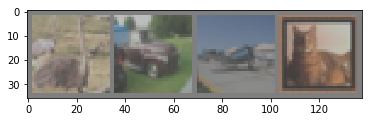

 bird   car plane   cat


In [11]:
import matplotlib.pyplot as plt
import numpy as np

#fucntion to show images

def imshow(img):
    img=img/4 +0.5 #unnormalize
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    
# get some random training images

dataiter = iter(trainloader)
images,labels = dataiter.next()

#show images
imshow(torchvision.utils.make_grid(images))

#print labels
print(' '.join('%5s'% classes[labels[j]] for j in range(4)))


# Define a Convolutional Neural Network


In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #3 input image , 6 output channels and 5x5 squares
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
        

In [13]:
#Define a loss function

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum = 0.9)

In [15]:
# Train the network

for epoch in range(2):
    
    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        #get the inputs
        inputs, labels = data
        
        #zero the parameters gradients
        optimizer.zero_grad()
        
        #forward + backward+ optimize
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        #print the statistics
        running_loss += loss.item()
        if i %2000 == 1999: #print every 2000 mini-batches
            print('[%d,%5d] loss: %.3f'% (epoch +1,i+1,running_loss/2000))
            
            running_loss = 0.0
            
print('Finished Training')
            

[1, 2000] loss: 1.875
[1, 4000] loss: 1.684
[1, 6000] loss: 1.583
[1, 8000] loss: 1.526
[1,10000] loss: 1.467
[1,12000] loss: 1.437
[2, 2000] loss: 1.379
[2, 4000] loss: 1.353
[2, 6000] loss: 1.329
[2, 8000] loss: 1.287
[2,10000] loss: 1.279
[2,12000] loss: 1.251
Finished Training


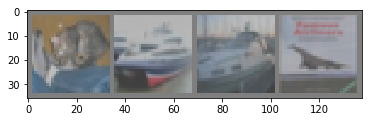

('GroundTruth:', '  cat  ship  ship plane')


In [17]:
dataiter = iter(testloader)
images,labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join('%5s' %classes[labels[j]] for j in range(4)))

In [19]:
output = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

('Predicted: ', ' frog  deer   dog  ship')


In [20]:
correct =0
total =0
with torch.no_grad():
    for data in testloader:
        images , labels = data
        outputs = net(images)
        _,predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of network on the 10000 test images: %d %%'%(100*correct/total))


Accuracy of network on the 10000 test images: 54 %


In [21]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 59 %
Accuracy of   car : 69 %
Accuracy of  bird : 31 %
Accuracy of   cat : 21 %
Accuracy of  deer : 51 %
Accuracy of   dog : 62 %
Accuracy of  frog : 59 %
Accuracy of horse : 70 %
Accuracy of  ship : 54 %
Accuracy of truck : 66 %


In [24]:
#Testing the cuda and training the data on GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)

cpu
